In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = "arial"

In [8]:
# import data
src = pd.ExcelFile(r'20241210 Wide OD, GC, NMR data.xlsx')
df = pd.read_excel(src, '20241210')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   code              137 non-null    object 
 1   start_OD          137 non-null    float64
 2   glycerol_start    137 non-null    float64
 3   propanoate_start  137 non-null    float64
 4   acetate_start     137 non-null    float64
 5   ethanol_start     122 non-null    float64
 6   end_OD            137 non-null    float64
 7   propanoate_end    137 non-null    float64
 8   acetate_end       137 non-null    float64
dtypes: float64(8), object(1)
memory usage: 9.8+ KB


In [9]:
df = df.fillna(0)
df

,code,start_OD,glycerol_start,propanoate_start,acetate_start,ethanol_start,end_OD,propanoate_end,acetate_end
0,207-1.1,0.1304,0.00000,0.0,0.041074,0.000000,0.3196,0.000000,33.733964
1,207-1.2,0.1294,0.00000,0.0,0.027743,0.000000,0.3017,0.000000,25.910399
2,207-1.3,0.1269,0.00000,0.0,0.031323,0.000000,0.2556,0.000000,33.547364
3,207-2.1,0.1258,0.00000,0.0,0.054683,0.000000,0.3875,0.000000,27.706751
4,207-2.2,0.1118,0.00000,0.0,0.026052,0.000000,0.2951,0.000000,30.133015
...,...,...,...,...,...,...,...,...,...
132,290-1.2,0.0839,4.02706,0.0,2.414326,0.300311,0.6823,1.223993,37.402965
133,290-1.3,0.0832,3.98849,0.0,2.453784,0.297359,0.3368,1.602649,12.053561
134,294-1.1,0.0778,0.00000,0.0,1.829625,0.500234,0.3367,0.605349,30.178702
135,294-1.2,0.0786,0.00000,0.0,1.741903,0.431771,0.2165,0.652406,18.566423


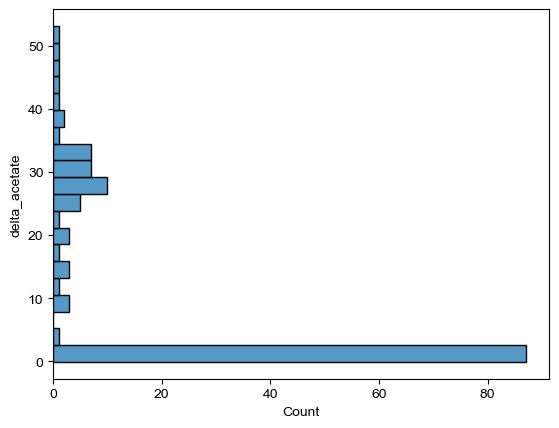

In [10]:
# drop unneccesary columns
columns_to_drop = ['code']
df.drop(axis=1, columns=columns_to_drop, inplace=True)

# calculate delat_acetate, this is the target variable
df['delta_acetate'] = df['acetate_end'] - df['acetate_start']

# plot violin plot to see distribution of delta_acetate
fig1 = sns.histplot(y='delta_acetate', data=df, bins=20);

In [11]:
df['delta_acetate'].describe()

count    137.000000
mean      10.136344
std       14.547567
min       -0.115981
25%        0.084083
50%        0.225993
75%       25.403994
max       53.165071
Name: delta_acetate, dtype: float64

In [12]:
# create two categories for acetate
# assign high to delta_acetate above mean, and low to delta_acetate below mean
# set min_1 to the minimum value minus 1 to include the minimum value in the cut
min_1 = df['delta_acetate'].min() - 1
y = pd.cut(df['delta_acetate'],
                          bins=[min_1, df['delta_acetate'].mean(), df['delta_acetate'].max()],
                          labels=[ "Low", "High"]) 
y.value_counts()

delta_acetate
Low     90
High    47
Name: count, dtype: int64

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\mims3\AppData\Local\Temp\ipykernel_1684\2225276312.py:4: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta$[AcO$^-$] (mM)', fontsize=14)


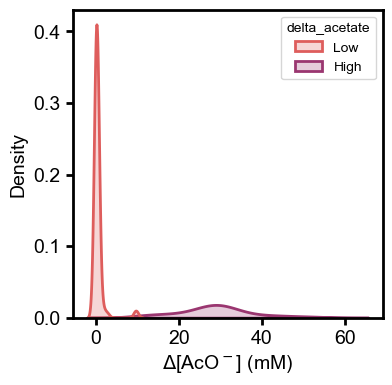

In [13]:
plt.figure(figsize=(4,4), linewidth=2)
ax = sns.kdeplot(data=df, x='delta_acetate', hue=y, fill=True,
                 palette='flare', linewidth=2)
ax.set_xlabel('$\Delta$[AcO$^-$] (mM)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.tick_params(axis='x', width=2, labelsize=14, length=5)
ax.tick_params(axis='y', direction='out', width=2, labelsize=14, length=5, right=False)

#Set axis linewidths
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

In [14]:
# create a dataframe containing only the start data
start_columns = []

for col in df.columns.to_list():
    if 'start' in col:
        start_columns.append(col)

X = df[start_columns]

<Axes: >

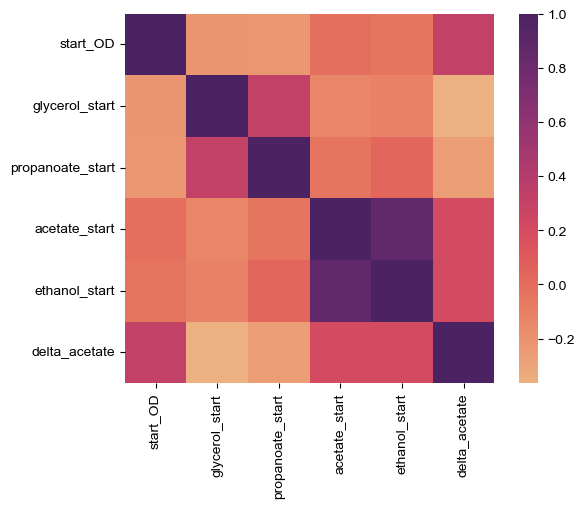

In [15]:
df_corr = X.copy()
df_corr['delta_acetate'] = df['delta_acetate']
cmatrix = df_corr.corr()
sns.heatmap(cmatrix, cmap='flare', square=True)

In [16]:
# standardise the data for mean=0 and variance=1
scaler = StandardScaler()
scaler.fit_transform(X);

In [17]:
# cross validation
model = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True)
metrics = {'accuracy': 'accuracy','precision': 'precision_macro', 'recall': 'recall_macro', 'f1': 'f1_macro'}
scores = cross_validate(model, X, y, cv=cv, scoring=metrics)
scores_df = pd.DataFrame(scores)
scores_df.mean()

fit_time          0.018365
score_time        0.017971
test_accuracy     0.816667
test_precision    0.823814
test_recall       0.850000
test_f1           0.810889
dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

# fit on training set only
scaler.fit(X_train)

# apply transform to both the training set and the test set
input_train = scaler.transform(X_train)
input_test = scaler.transform(X_test)

model_1 = model.fit(X_train, y_train)
model_1_score = model.score(X_train, y_train)
print(f'Accuracy score on training data: {model_1_score:.2f}')

model_1_test_score = model.score(X_test, y_test)
print(f'Accuracy score on test data: {model_1_test_score:.2f}')

# find weighting of features
weight = model.coef_
# high = 0 and low = 1, so multiply weight by -1 to make more intuitive sense
weight = weight * -1

Accuracy score on training data: 0.78
Accuracy score on test data: 0.79


In [19]:
d = dict(zip(X.columns.tolist(), weight[0].tolist()))
d

{'start_OD': 0.6543382547037851,
 'glycerol_start': -0.2667346641128121,
 'propanoate_start': -0.4777659768930926,
 'acetate_start': 0.10469557644695718,
 'ethanol_start': 1.801729937636446}

In [20]:
y_pred = model.predict(X_test)
y_test.value_counts()

delta_acetate
Low     18
High    10
Name: count, dtype: int64

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.62      1.00      0.77        10
         Low       1.00      0.67      0.80        18

    accuracy                           0.79        28
   macro avg       0.81      0.83      0.78        28
weighted avg       0.87      0.79      0.79        28



In [22]:
for p0, p1 in model.predict_proba(X_test):
    print(f"p(0) = {p0:.2f} \tp(1) = {p1:.2f}")

p(0) = 0.53 	p(1) = 0.47
p(0) = 0.39 	p(1) = 0.61
p(0) = 0.73 	p(1) = 0.27
p(0) = 0.53 	p(1) = 0.47
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.39 	p(1) = 0.61
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.79 	p(1) = 0.21
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.68 	p(1) = 0.32
p(0) = 0.76 	p(1) = 0.24
p(0) = 0.01 	p(1) = 0.99
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.79 	p(1) = 0.21
p(0) = 0.79 	p(1) = 0.21
p(0) = 0.72 	p(1) = 0.28
p(0) = 0.73 	p(1) = 0.27
p(0) = 0.84 	p(1) = 0.16
p(0) = 0.74 	p(1) = 0.26
p(0) = 0.84 	p(1) = 0.16
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.52 	p(1) = 0.48
p(0) = 0.71 	p(1) = 0.29
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.71 	p(1) = 0.29
p(0) = 0.00 	p(1) = 1.00
p(0) = 0.00 	p(1) = 1.00


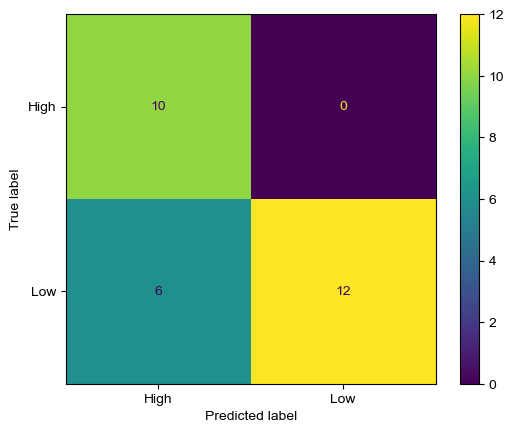

In [26]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=model.classes_)
cm_display.plot()
plt.show()